In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam3/blob/main/notebooks/sam3_image_interactive.ipynb">
#   <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
# </a>

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib scikit-learn
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam3.git'

In [4]:
%matplotlib widget

In [5]:
import torch
# turn on tfloat32 for Ampere GPUs
# https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# use bfloat16 for the entire notebook. If your card doesn't support it, try float16 instead
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

# inference mode for the whole notebook. Disable if you need gradients
torch.inference_mode().__enter__()

# Load the model

In [6]:
import sam3
from sam3 import build_sam3_image_model
import os
sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")
bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"

In [7]:
model = build_sam3_image_model(bpe_path=bpe_path)

[INFO] 创建视觉编码器...
[INFO] 视觉编码器创建完成 (耗时 9.0 秒)
[INFO] 创建文本编码器...
[INFO] 文本编码器创建完成 (耗时 2.6 秒)
[INFO] 创建视觉-语言 backbone...
[INFO] backbone 创建完成 (耗时 0.0 秒)
[INFO] 创建 Transformer...
[INFO] Transformer 创建完成 (耗时 0.2 秒)
[INFO] 创建 dot product scoring...
[INFO] dot product scoring 创建完成 (耗时 0.0 秒)
[INFO] 创建分割头...
[INFO] 分割头创建完成 (耗时 0.0 秒)
[INFO] 创建几何编码器...
[INFO] 几何编码器创建完成 (耗时 0.1 秒)
[INFO] 组装 SAM3 模型...
[INFO] 模型组装完成 (耗时 0.0 秒)
[INFO] 模型结构创建总耗时: 11.9 秒
[INFO] 开始加载 checkpoint: /mnt/d/AI/sam-3d-objects-main/external/sam3/checkpoints/sam3.pt
[INFO] checkpoint 文件读取完成 (耗时 30.1 秒)
[INFO] checkpoint 键名处理完成 (耗时 0.0 秒)
[INFO] 模型权重加载完成 (耗时 0.1 秒)
[INFO] checkpoint 加载总耗时: 30.2 秒
[INFO] 正在将模型转移到 GPU...
[INFO] 模型转移到 GPU 完成 (耗时 2.4 秒)


In [8]:
from sam3.model.sam3_image_processor import Sam3Processor
processor = Sam3Processor(model)

# Jupyter widget

In [9]:
import io

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import requests
from IPython.display import clear_output, display, HTML
from matplotlib.patches import Rectangle


class Sam3SegmentationWidget:
    """Interactive Jupyter widget for SAM3 segmentation with text and box prompts."""

    def __init__(self, processor):
        """
        Initialize the segmentation widget.

        Args:
            processor: Sam3Processor instance
        """
        self.processor = processor
        self.state = None
        self.current_image = None
        self.current_image_array = None
        self.box_mode = "positive"
        self.drawing_box = False
        self.box_start = None
        self.current_rect = None

        self._setup_ui()
        self._setup_plot()

    def _setup_ui(self):
        """Set up the UI components."""
        self.upload_widget = widgets.FileUpload(
            accept="image/*", multiple=False, description="Upload Image"
        )
        self.upload_widget.observe(self._on_image_upload, names="value")

        self.url_input = widgets.Text(
            placeholder="Or enter image URL",
        )
        self.url_button = widgets.Button(description="Load URL", button_style="info")
        self.url_button.on_click(self._on_load_url)
        url_box = widgets.HBox(
            [self.url_input, self.url_button],
            layout=widgets.Layout(width="100%", justify_content="space-between"),
        )

        self.text_input = widgets.Text(
            placeholder='Enter segmentation prompt (e.g., "person", "dog")',
            continuous_update=False,
        )
        self.text_input.observe(self._on_text_submit, names="value")
        self.text_button = widgets.Button(description="Segment", button_style="success")
        self.text_button.on_click(self._on_text_prompt)
        text_box = widgets.HBox(
            [self.text_input, self.text_button],
            layout=widgets.Layout(width="100%", justify_content="space-between"),
        )

        self.box_mode_buttons = widgets.ToggleButtons(
            options=["Positive Boxes", "Negative Boxes"],
            description="Box Mode:",
            button_style="",
            tooltips=[
                "Draw boxes around objects to include",
                "Draw boxes around objects to exclude",
            ],
        )
        self.box_mode_buttons.observe(self._on_box_mode_change, names="value")

        self.clear_button = widgets.Button(
            description="Clear All Prompts", button_style="warning"
        )
        self.clear_button.on_click(self._on_clear_prompts)

        self.confidence_slider = widgets.FloatSlider(
            value=0.5,
            min=0.0,
            max=1.0,
            step=0.01,
            description="Confidence:",
            continuous_update=False,
            style={"description_width": "initial"},
        )
        self.confidence_slider.observe(self._on_confidence_change, names="value")

        self.size_slider = widgets.IntSlider(
            value=960,
            min=300,
            max=2000,
            step=10,
            description="Image Size:",
            continuous_update=False,
            style={"description_width": "initial"},
        )
        self.size_slider.observe(self._on_size_change, names="value")

        slider_box = widgets.HBox(
            [self.confidence_slider, self.size_slider],
            layout=widgets.Layout(justify_content="space-between"),
        )

        self.output = widgets.Output()
        self.status_label = widgets.Label(value="Upload an image to begin")

        # This box will hold our matplotlib output and we can target it with CSS.
        self.plot_container = widgets.Box([self.output])
        self.plot_container.add_class("no-drag")

        # CSS to make the cursor a crosshair over the matplotlib canvas
        css_style = widgets.HTML(
            """
        <style>
            .jupyter-matplotlib-canvas, canvas {
                cursor: crosshair !important;
            }
        </style>
        """
        )
        # Create VBoxes for each accordion pane
        source_pane = widgets.VBox([self.upload_widget, url_box])
        prompt_pane = widgets.VBox(
            [
                widgets.Label("Text Prompt:"),
                text_box,
                self.box_mode_buttons,
                self.confidence_slider,
                self.clear_button,
            ]
        )
        display_pane = widgets.VBox([self.size_slider])

        # Create the Accordion to hold the control panes
        self.accordion = widgets.Accordion(
            children=[source_pane, prompt_pane, display_pane]
        )
        self.accordion.set_title(0, "Image Source")
        self.accordion.set_title(1, "Segmentation Prompts")
        self.accordion.set_title(2, "Display Settings")
        self.accordion.selected_index = 0  # Start with the first pane open

        # Create the left sidebar for controls
        sidebar = widgets.VBox(
            [self.status_label, widgets.HTML("<h4>Controls</h4>"), self.accordion]
        )
        sidebar.layout = widgets.Layout(
            width="380px",
            min_width="380px",
            max_width="380px",
            border="1px solid #e0e0e0",
            padding="10px",
            margin="0 15px 0 0",
            flex="0 0 auto",
        )

        # Create the main area for the image display
        main_area = widgets.VBox([self.plot_container])
        main_area.layout = widgets.Layout(flex="1", min_width="500px", overflow="auto")

        # Combine sidebar and main area into the final app layout
        app_layout = widgets.HBox([sidebar, main_area])
        app_layout.layout = widgets.Layout(
            width="100%",
            display="flex",
            flex_flow="row",
            align_items="stretch",
        )

        # Set the main container
        self.container = widgets.VBox(
            [
                css_style,
                widgets.HTML("<h3>🖼️ SAM3 Interactive Segmentation</h3>"),
                app_layout,
            ]
        )

    def _setup_plot(self):
        """Set up the matplotlib figure."""
        # plt.ioff()
        self.fig, self.ax = plt.subplots(figsize=(12, 8))
        # plt.ion()
        self.ax.axis("off")
        self.fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
        self.fig.canvas.toolbar_visible = False
        self.fig.canvas.header_visible = False
        self.fig.canvas.footer_visible = False
        self.fig.canvas.resizable = False

        # plt.close(self.fig)

    def _set_loading(self, is_loading, message="Processing..."):
        """Show/hide loading state and disable/enable controls."""
        if is_loading:
            self.status_label.value = f"⏳ {message}"
            self.upload_widget.disabled = True
            self.url_button.disabled = True
            self.text_button.disabled = True
            self.clear_button.disabled = True
            self.box_mode_buttons.disabled = True
            self.confidence_slider.disabled = True
        else:
            self.upload_widget.disabled = False
            self.url_button.disabled = False
            self.text_button.disabled = False
            self.clear_button.disabled = False
            self.box_mode_buttons.disabled = False
            self.confidence_slider.disabled = False

    def _on_image_upload(self, change):
        """Handle image upload."""
        if change["new"]:
            uploaded_file = change["new"][0]
            image = PIL.Image.open(io.BytesIO(uploaded_file["content"])).convert("RGB")
            self._set_image(image)

    def _on_load_url(self, button):
        """Handle loading image from URL."""
        url = self.url_input.value.strip()
        if not url:
            self.status_label.value = "Please enter a URL"
            return

        self._set_loading(True, "Downloading image from URL...")

        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            image = PIL.Image.open(io.BytesIO(response.content)).convert("RGB")
            self._set_image(image)
        except Exception as e:
            self._set_loading(False)
            self.status_label.value = f"Error loading image: {str(e)}"

    def _set_image(self, image):
        """Set the current image, adjust figure size, and initialize state."""
        self._set_loading(True, "Processing image through model...")

        try:

            self.current_image = image
            self.current_image_array = np.array(image)
            self.state = self.processor.set_image(image)
            self._set_loading(False)
            self.status_label.value = (
                f"Image loaded: {image.size[0]}x{image.size[1]} pixels"
            )
            self._resize_figure()
            self._update_display()
            self._connect_plot_events()
            self.accordion.selected_index = 1
        except Exception as e:
            self._set_loading(False)
            self.status_label.value = f"Error processing image: {str(e)}"

    def _on_text_submit(self, change):
        """Handle text prompt submission via Enter key."""
        # Call the same handler as the button click
        self._on_text_prompt(None)

    def _on_text_prompt(self, button):
        """Handle text prompt submission."""
        if self.state is None:
            self.status_label.value = "Please load an image first"
            return

        prompt = self.text_input.value.strip()
        if not prompt:
            self.status_label.value = "Please enter a prompt"
            return

        self._set_loading(True, f'Segmenting with prompt: "{prompt}"...')

        try:
            self.state = self.processor.set_text_prompt(prompt, self.state)
            self._set_loading(False)
            self.status_label.value = f'Segmented with prompt: "{prompt}"'
            self._update_display()
        except Exception as e:
            self._set_loading(False)
            self.status_label.value = f"Error: {str(e)}"

    def _on_box_mode_change(self, change):
        """Handle box mode toggle."""
        self.box_mode = "positive" if change["new"] == "Positive Boxes" else "negative"

    def _on_clear_prompts(self, button):
        """Clear all prompts and reset to image only."""
        if self.current_image is not None:
            try:
                self._set_loading(True, "Clearing prompts and resetting...")
                self.state = self.processor.reset_all_prompts(self.state)
                if "prompted_boxes" in self.state:
                    del self.state["prompted_boxes"]
                self.text_input.value = ""
                self._set_loading(False)
                self.status_label.value = "Cleared all prompts"
                self._update_display()
            except Exception as e:
                self._set_loading(False)
                import traceback

                self.status_label.value = f"Error: {str(e)} {traceback.format_exc()}"

    def _on_confidence_change(self, change):
        """Handle confidence threshold change."""
        if self.state is not None:
            self.state = self.processor.set_confidence_threshold(
                change["new"], self.state
            )
            self._update_display()

    def _connect_plot_events(self):
        """Connect matplotlib event handlers for box drawing."""
        # Disable matplotlib's toolbar navigation to allow custom box drawing
        if hasattr(self.fig.canvas, "toolbar") and self.fig.canvas.toolbar is not None:
            self.fig.canvas.toolbar.pan()
            self.fig.canvas.toolbar.pan()

        self.fig.canvas.mpl_connect("button_press_event", self._on_press)
        self.fig.canvas.mpl_connect("button_release_event", self._on_release)
        self.fig.canvas.mpl_connect("motion_notify_event", self._on_motion)

    def _on_press(self, event):
        """Handle mouse press for box drawing."""
        if event.inaxes != self.ax:
            return
        self.drawing_box = True
        self.box_start = (event.xdata, event.ydata)

    def _on_motion(self, event):
        """Handle mouse motion for box preview."""
        if not self.drawing_box or event.inaxes != self.ax or self.box_start is None:
            return

        if self.current_rect is not None:
            self.current_rect.remove()

        x0, y0 = self.box_start
        x1, y1 = event.xdata, event.ydata
        width = x1 - x0
        height = y1 - y0

        color = "green" if self.box_mode == "positive" else "red"
        self.current_rect = Rectangle(
            (x0, y0),
            width,
            height,
            fill=False,
            edgecolor=color,
            linewidth=2,
            linestyle="--",
        )
        self.ax.add_patch(self.current_rect)
        self.fig.canvas.draw_idle()

    def _on_release(self, event):
        """Handle mouse release to finalize box."""
        if not self.drawing_box or event.inaxes != self.ax or self.box_start is None:
            self.drawing_box = False
            return

        self.drawing_box = False

        if self.current_rect is not None:
            self.current_rect.remove()
            self.current_rect = None

        if self.state is None:
            return

        x0, y0 = self.box_start
        x1, y1 = event.xdata, event.ydata

        x_min = min(x0, x1)
        x_max = max(x0, x1)
        y_min = min(y0, y1)
        y_max = max(y0, y1)

        if abs(x_max - x_min) < 5 or abs(y_max - y_min) < 5:
            return

        # Get image dimensions
        img_h = self.state["original_height"]
        img_w = self.state["original_width"]

        # Convert from xyxy pixel coordinates to cxcywh normalized format
        center_x = (x_min + x_max) / 2.0 / img_w
        center_y = (y_min + y_max) / 2.0 / img_h
        width = (x_max - x_min) / img_w
        height = (y_max - y_min) / img_h

        box = [center_x, center_y, width, height]
        label = self.box_mode == "positive"
        mode_str = "positive" if label else "negative"

        # Store the prompted box in pixel coordinates for display
        if "prompted_boxes" not in self.state:
            self.state["prompted_boxes"] = []
        self.state["prompted_boxes"].append(
            {"box": [x_min, y_min, x_max, y_max], "label": label}
        )

        self._set_loading(True, f"Adding {mode_str} box and re-segmenting...")

        try:
            self.state = self.processor.add_geometric_prompt(box, label, self.state)
            self._set_loading(False)
            self.status_label.value = f"Added {mode_str} box"
            self._update_display()
        except Exception as e:
            self._set_loading(False)
            self.status_label.value = f"Error adding box: {str(e)}"

    def _resize_figure(self):
        """Calculate and apply new figure size based on image and slider value."""
        if self.current_image is None:
            return

        # 1. Get original image dimensions
        img_w, img_h = self.current_image.size

        # 2. The slider's value is now the direct target width for the display
        display_w = float(self.size_slider.value)

        # 3. Calculate the corresponding height to maintain the original aspect ratio
        aspect_ratio = img_h / img_w
        display_h = int(display_w * aspect_ratio)

        # 4. Convert pixel dimensions to inches for Matplotlib and apply
        dpi = self.fig.dpi
        new_figsize = (display_w / dpi, display_h / dpi)
        self.fig.set_size_inches(new_figsize, forward=True)

    def _on_size_change(self, change):
        """Handle a change from the image size slider."""
        if self.current_image is not None:
            self._resize_figure()
            # After resizing the canvas, we must redraw the content
            self._update_display()

    def _update_display(self):
        """Update the display with current results."""
        if self.current_image_array is None:
            return

        with self.output:
            clear_output(wait=True)

            self.ax.clear()
            self.ax.axis("off")
            self.ax.imshow(self.current_image_array)

            if self.state is not None and "masks" in self.state:
                masks = self.state.get("masks", [])
                boxes = self.state.get("boxes", [])
                scores = self.state.get("scores", [])

                if len(masks) > 0:
                    mask_overlay = np.zeros((*self.current_image_array.shape[:2], 4))

                    for i, (mask, box, score) in enumerate(zip(masks, boxes, scores)):
                        mask_np = mask[0].cpu().numpy()

                        color = plt.cm.tab10(i % 10)[:3]
                        mask_overlay[mask_np > 0.5] = (*color, 0.5)

                        x0, y0, x1, y1 = box.cpu().numpy()
                        rect = Rectangle(
                            (x0, y0),
                            x1 - x0,
                            y1 - y0,
                            fill=False,
                            edgecolor=color,
                            linewidth=2,
                        )
                        self.ax.add_patch(rect)

                        self.ax.text(
                            x0,
                            y0 - 5,
                            f"{score:.2f}",
                            color="white",
                            fontsize=10,
                            bbox=dict(
                                facecolor=color, alpha=0.7, edgecolor="none", pad=2
                            ),
                        )

                    self.ax.imshow(mask_overlay)
                    self.status_label.value = f"Found {len(masks)} object(s)"
                else:
                    self.status_label.value = (
                        "No objects found above confidence threshold"
                    )

            # Display prompted boxes with dashed lines
            if self.state is not None and "prompted_boxes" in self.state:
                for prompted_box in self.state["prompted_boxes"]:
                    box_coords = prompted_box["box"]
                    is_positive = prompted_box["label"]

                    x0, y0, x1, y1 = box_coords
                    color = "green" if is_positive else "red"

                    rect = Rectangle(
                        (x0, y0),
                        x1 - x0,
                        y1 - y0,
                        fill=False,
                        edgecolor=color,
                        linewidth=2,
                        linestyle="--",
                    )
                    self.ax.add_patch(rect)

            # display(self.fig.canvas)

    def display(self):
        display(self.container)

    # Add this for more convenient display in notebooks
    def _ipython_display_(self):
        self.display()


# Run!

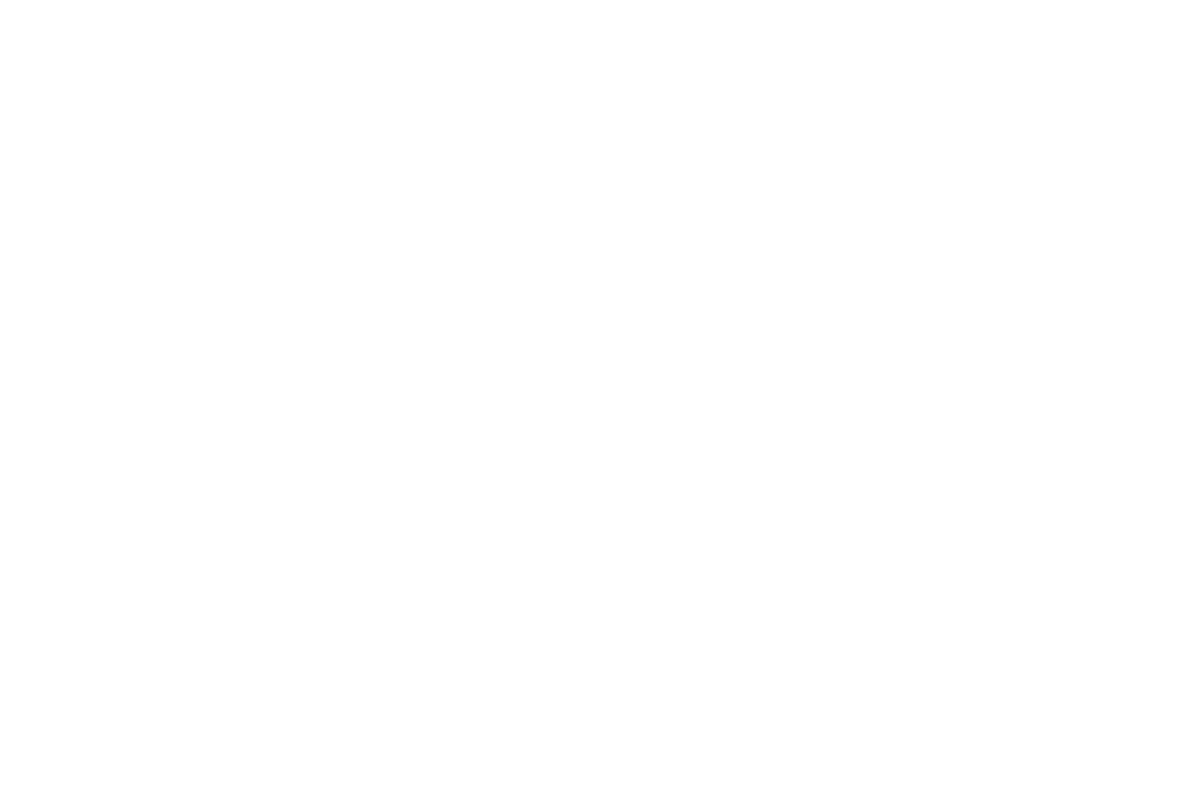

In [10]:
widget = Sam3SegmentationWidget(processor)
widget.display()